In [354]:
packages <- c("dplyr","readxl","tidyverse", "bookdown", "car", "ivreg", "sandwich", "rddensity", "rdrobust", "fixest", "Synth", "lubridate", "modelsummary")
package.check <- lapply(packages, FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
        install.packages(x, dependencies = TRUE)
        library(x, character.only = TRUE)
    }
})

In [355]:
df <- read.csv("../data/nishitateno_burke_2020.csv", sep = ";")

In [730]:
first_date <- as.Date("1981-01-01")
last_date <- as.Date("2015-12-01")
# create a table with all the dates between first_date and last_date and the absolute number of months starting at 252
dates <- data.frame(
  y_date = seq(first_date, last_date, by = "month"),
  y_month = seq(252, 671, by = 1)
)

# get y_month where y_date is 1992-06-01
dates %>% 
  filter(y_date == "1992-06-01")

y_date,y_month
<date>,<dbl>
1992-06-01,389


In [357]:
df <- merge(dates, df, by = "y_month", all.x = TRUE)

In [358]:
# get the actual value from the log of nnd
df$average_ndd <- exp(df$lnaverage_ndd) %>% round(2)

In [406]:
head(df)

,y_month,y_date,lnaverage_ndd,lnhmax_ndd,treatment_effects,temp,precip,wind,daylight,snow,cloud,treatment1992,m_code,dabove_nd,average_ndd,month,year
,<dbl>,<date>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,252,1981-01-01,3.044523,4.094345,0,-4.9,162.0,1.5,134.3,273,7.3,0,1101080,0,21,1,1981
2,252,1981-01-01,3.465736,4.605170,0,3.9,6.0,2.4,222.4,0,3.0,1,12204520,0,32,1,1981
3,252,1981-01-01,3.610918,4.382027,0,4.4,3.5,3.5,233.4,0,2.9,1,13112510,0,37,1,1981
4,252,1981-01-01,3.091043,4.700480,0,4.4,3.5,3.5,233.4,0,2.9,1,11214030,0,22,1,1981
5,252,1981-01-01,3.784190,4.700480,0,4.4,4.0,2.2,218.0,0,2.9,1,14101520,2,44,1,1981
6,252,1981-01-01,3.610918,4.605170,0,4.4,3.5,3.5,233.4,0,2.9,1,13108520,0,37,1,1981


In [359]:
# mean of lnaverage_ndd
nnd_graph <- df %>% 
    group_by(y_date, treatment_effects) %>%
    summarize(average_ndd_mean = mean(average_ndd))

`summarise()` has grouped output by 'y_date'. You can override using the
`.groups` argument.


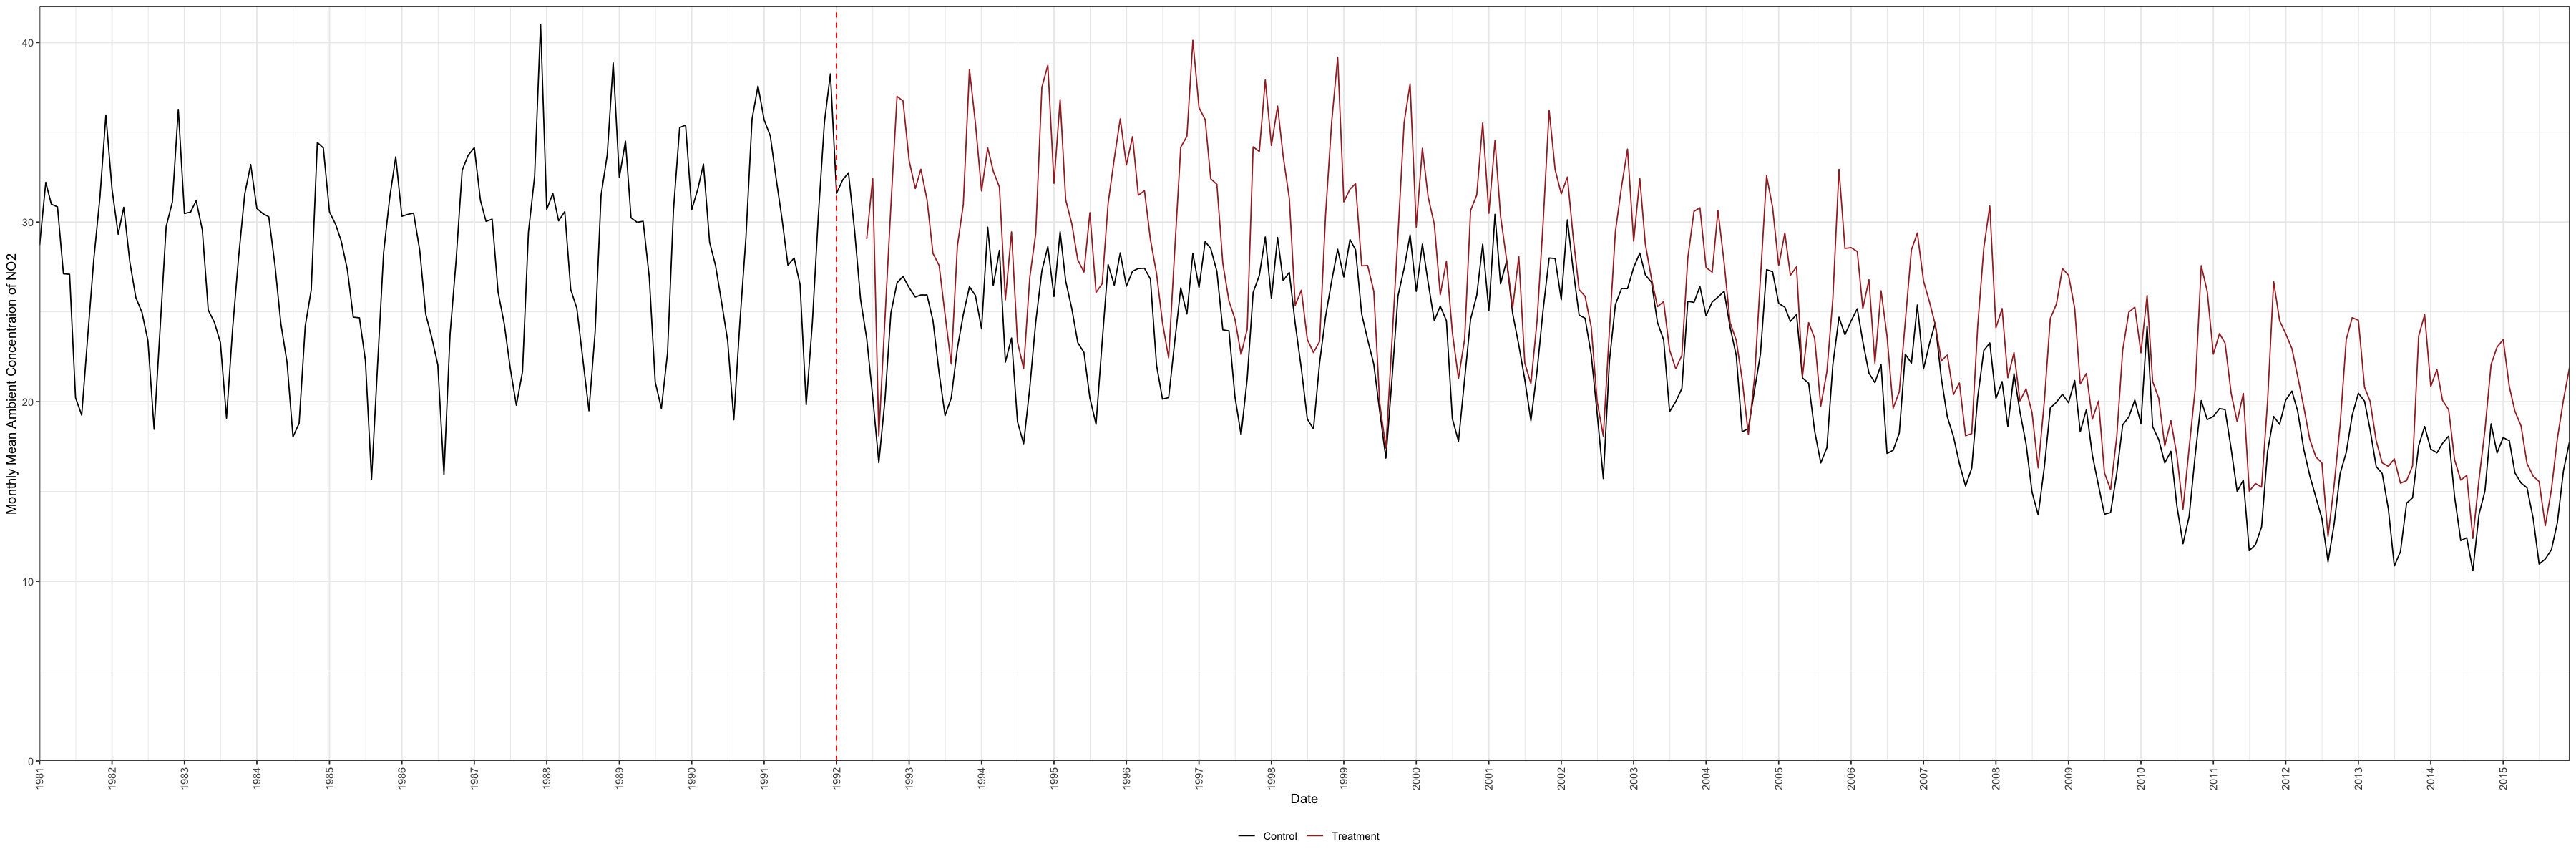

In [360]:
options(repr.plot.width=30, repr.plot.height=10)
ggplot(data = nnd_graph, 
       mapping = aes(y=average_ndd_mean,
                    x=y_date,
                    color=factor(treatment_effects))) +
  geom_line(size = 0.5) +
  guides(color = guide_legend(title = element_blank())) +
  scale_color_manual(labels = c("Control", "Treatment"), 
                     values = c("black", "brown")) +
  labs(x = "Date", y = "Monthly Mean Ambient Concentraion of NO2") +
  # add each year y_date as year label
  scale_x_date(date_breaks = "1 year", date_labels = "%Y", expand = c(0, 0)) +
  # scale y axis from 0 to 50
  scale_y_continuous(limits = c(0, 42), expand = c(0,0)) +
  # add a vertical line at year 1992
  geom_vline(xintercept = as.Date("1992-01-01"), linetype = "dashed", color = "red") +
  theme_bw() + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), legend.position = "bottom")

In [361]:
# add month and year column
df$month <- month(df$y_date)
df$year <- year(df$y_date)

In [362]:
head(df)

,y_month,y_date,lnaverage_ndd,lnhmax_ndd,treatment_effects,temp,precip,wind,daylight,snow,cloud,treatment1992,m_code,dabove_nd,average_ndd,month,year
,<dbl>,<date>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,252,1981-01-01,3.044523,4.094345,0,-4.9,162.0,1.5,134.3,273,7.3,0,1101080,0,21,1,1981
2,252,1981-01-01,3.465736,4.605170,0,3.9,6.0,2.4,222.4,0,3.0,1,12204520,0,32,1,1981
3,252,1981-01-01,3.610918,4.382027,0,4.4,3.5,3.5,233.4,0,2.9,1,13112510,0,37,1,1981
4,252,1981-01-01,3.091043,4.700480,0,4.4,3.5,3.5,233.4,0,2.9,1,11214030,0,22,1,1981
5,252,1981-01-01,3.784190,4.700480,0,4.4,4.0,2.2,218.0,0,2.9,1,14101520,2,44,1,1981
6,252,1981-01-01,3.610918,4.605170,0,4.4,3.5,3.5,233.4,0,2.9,1,13108520,0,37,1,1981


In [400]:
# fixed effects months + Monitor fixed effects (225 - m_code)
model1 <- feols(fml = lnaverage_ndd ~ treatment_effects * treatment1992 | month + m_code, data = df)
# fixed effects months + Monitor fixed effects + Weather variables
model2 <- feols(fml = lnaverage_ndd ~ treatment_effects * treatment1992 + temp + precip + daylight + snow + wind + cloud | month + m_code, data = df)

# EXTRA: fixed effects months, weather and Monitor-specific time trends
model3 <- feols(fml = lnaverage_ndd ~ treatment_effects * treatment1992 + temp + precip + daylight + snow + wind + cloud | month * year + m_code, data = df)

# Coefficients of the treatment variable when the pollution variables are measured by
# Hourly maximum
model4 <- feols(fml = lnhmax_ndd ~ treatment_effects * treatment1992 + temp + precip + daylight + snow + wind + cloud | month + m_code, data = df)
hourly_max <- coef(summary(model4))[["treatment_effects"]]
hourly_max
etable(model1, model2, model3, title = "Estimated Effects of Designation under the ANCL on Air Pollution")

The variables 'treatment1992' and 'treatment_effects:treatment1992' have been removed because of collinearity (see $collin.var).

The variables 'treatment1992' and 'treatment_effects:treatment1992' have been removed because of collinearity (see $collin.var).

The variables 'treatment1992' and 'treatment_effects:treatment1992' have been removed because of collinearity (see $collin.var).

The variables 'treatment1992' and 'treatment_effects:treatment1992' have been removed because of collinearity (see $collin.var).



[1] -0.1651359

,,model1,model2,model3
,<chr>,<chr>,<chr>,<chr>
1,Dependent Var.:,lnaverage_ndd,lnaverage_ndd,lnaverage_ndd
2,,,,
3,treatment_effects,-0.1288*** (0.0136),-0.1144*** (0.0154),-0.1280*** (0.0103)
4,temp,,0.0065 (0.0072),0.0168. (0.0078)
5,precip,,-0.0001 (7.32e-5),0.0002. (0.0001)
6,daylight,,-0.0038*** (0.0004),-0.0005. (0.0002)
7,snow,,0.0029*** (0.0004),0.0025*** (0.0003)
8,wind,,-0.0068 (0.0145),-0.0702*** (0.0114)
9,cloud,,-0.1506*** (0.0154),-0.0452** (0.0102)


In [480]:
# temperature mean
df %>% 
    summarize(temp_mean = mean(temp)) %>% 
    mutate(temp_mean = round(temp_mean))

# precipitation mean
df %>% 
    summarize(precip_mean = mean(precip)) %>% 
    mutate(precip_mean = round(precip_mean))

temp_mean
<dbl>
16


precip_mean
<dbl>
123


In [491]:
# temp * precip + temp * daylight + temp * snow + temp * cloud
#model_temp_test <- feols(fml = lnaverage_ndd ~ treatment_effects * treatment1992 + temp + daylight + snow + wind + cloud + temp * month | month + m_code, data = df)
model_temp_test <- feols(fml = lnaverage_ndd ~ treatment_effects * treatment1992 + temp + precip + daylight + snow + wind + cloud | month + m_code, data = df)

etable(model_temp_test)

The variables 'treatment1992' and 'treatment_effects:treatment1992' have been removed because of collinearity (see $collin.var).



,,model_temp_test
,<chr>,<chr>
1,Dependent Var.:,lnaverage_ndd
2,,
3,treatment_effects,-0.1144*** (0.0154)
4,temp,0.0065 (0.0072)
5,precip,-0.0001 (7.32e-5)
6,daylight,-0.0038*** (0.0004)
7,snow,0.0029*** (0.0004)
8,wind,-0.0068 (0.0145)
9,cloud,-0.1506*** (0.0154)


In [463]:
# plot the models the models and check if the standard errors are hetroskedastic
# robustness of fixed effects models?

ERROR: Error in xy.coords(x, y, xlabel, ylabel, log): 'x' is a list, but does not have components 'x' and 'y'


In [423]:
# treatment group is 109 designated municipalities with 190 monitors
df %>% 
    filter(treatment1992 == 1) %>%
    filter(treatment_effects == 1) %>%
    group_by(m_code) %>%
    summarize(n = n()) %>%
    nrow()

[1] 190

In [ ]:
# treatment group is 109 designated municipalities with 190 monitors
df %>% 
    filter(treatment1992 == 1) %>%
    filter(treatment_effects == 1) %>%
    group_by(m_code) %>%
    summarize(n = n())

m_code,n
<int>,<int>
11202040,282
11203030,276
11203050,272
11204010,281
11205040,282
11205050,283
11206020,279
11210010,283
11214030,282


In [ ]:
# The control group is five non-designated municipalities with 35 monitors.
df %>% 
    filter(treatment1992 == 0) %>%
    filter(treatment_effects == 0) %>%
    group_by(m_code) %>%
    summarize(n = n())

m_code,n
<int>,<int>
1101080,419
1102010,419
1102020,414
1103010,420
1105010,420
1107020,419
1107030,420
4201050,417
4201080,418


In [ ]:
# Hence, the 225 montiors are the m_code
df %>% 
    group_by(m_code) %>%
    summarize(n = n())

m_code,n
<int>,<int>
1101080,419
1102010,419
1102020,414
1103010,420
1105010,420
1107020,419
1107030,420
4201050,417
4201080,418


In [439]:
# How many have a treatment effect below the year 1992?
df %>% 
    filter(y_date < as.Date("1992-06-01")) %>%
    group_by(treatment_effects) %>%
    summarize(n = n())

treatment_effects,n
<int>,<int>
0,30340


In [440]:
df %>% 
    filter(y_date < as.Date("1992-06-01")) %>%
    group_by(treatment1992) %>%
    summarize(n = n())

treatment1992,n
<int>,<int>
0,4766
1,25574


In [441]:
# How many have a treatment effect above the year 1992?
df %>% 
    filter(y_date > as.Date("1992-06-01")) %>%
    group_by(treatment_effects) %>%
    summarize(n = n())

treatment_effects,n
<int>,<int>
0,9589
1,50272


In [442]:
df %>% 
    filter(y_date > as.Date("1992-06-01")) %>%
    group_by(treatment1992) %>%
    summarize(n = n())

treatment1992,n
<int>,<int>
0,9589
1,50272


In [452]:
df %>% 
    filter(y_date > as.Date("2016-01-01")) %>%
    summarize(n = n())

n
<int>
0


In [451]:
df %>% 
    #filter(y_date > as.Date("1992-06-01")) %>%
    filter(y_date < as.Date("2016-01-01")) %>%
    summarize(n = n())

n
<int>
90425


In [503]:
# for each year, calculate the average ndd by treatment1992
df %>%
    group_by(year, treatment1992) %>%
    summarize(mean_average_ndd = mean(average_ndd))

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


year,treatment1992,mean_average_ndd
<dbl>,<int>,<dbl>
1981,0,23.03390
1981,1,28.84357
1982,0,22.06522
1982,1,28.88241
1983,0,22.04808
1983,1,28.57284
1984,0,21.77619
1984,1,27.74597
1985,0,21.53477


`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


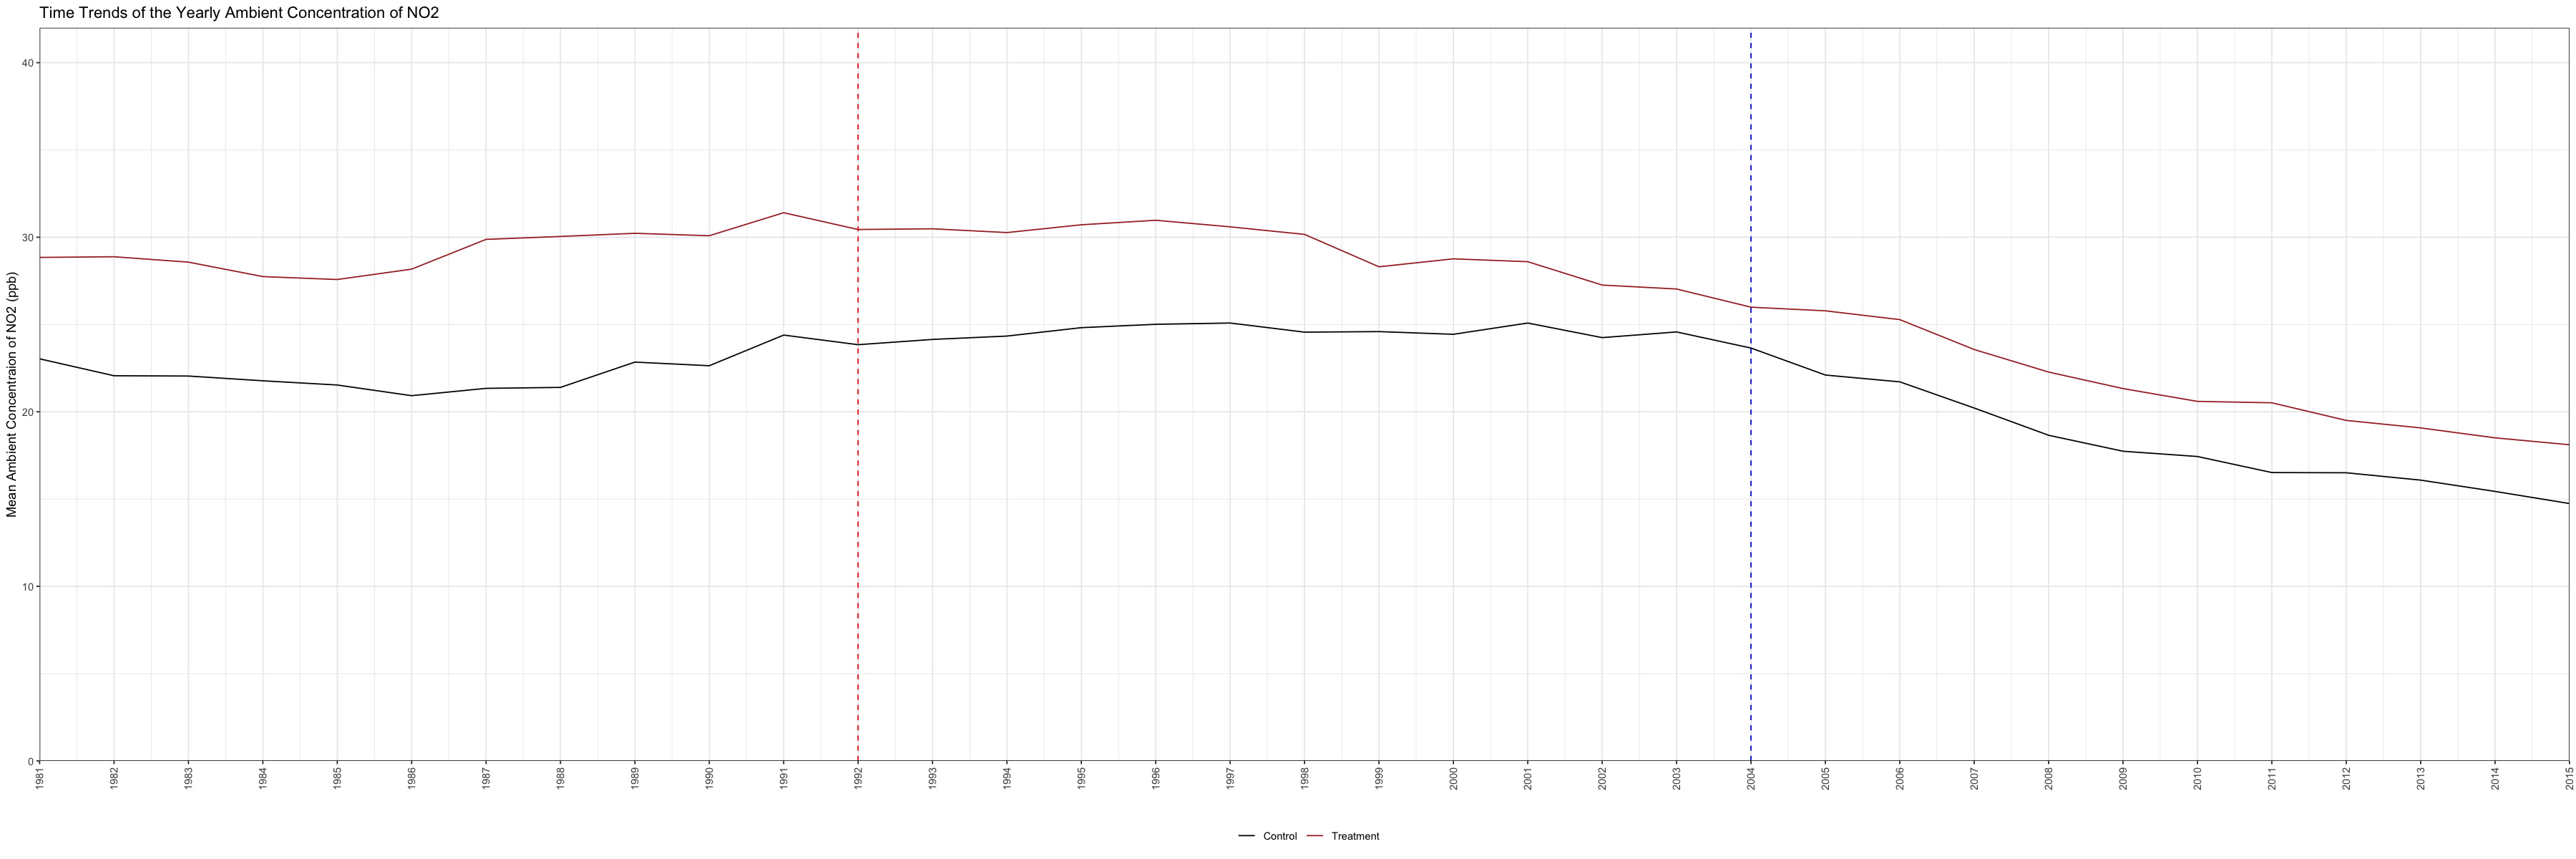

In [517]:
nnd_graph <- df %>%
    group_by(year, treatment1992) %>%
    summarize(mean_average_ndd = mean(average_ndd))

# plot the mean of average_ndd
ggplot(data = nnd_graph, 
       mapping = aes(y=mean_average_ndd,
                    x=year,
                    color=factor(treatment1992))) +
  geom_line(size = 0.5) +
  guides(color = guide_legend(title = element_blank())) +
  scale_color_manual(labels = c("Control", "Treatment"), 
                     values = c("black", "brown")) +
  labs(x="", 
       y = "Mean Ambient Concentraion of NO2 (ppb)",
       title = "Time Trends of the Yearly Ambient Concentration of NO2") +
  scale_x_continuous(breaks = seq(1981, 2015, 1), limits = c(1981, 2015), expand = c(0, 0)) +
  scale_y_continuous(limits = c(0, 42), expand = c(0,0)) +
  # Intervention is June 1992
  geom_vline(xintercept = 1992, linetype = "dashed", color = "red") +
  # government support in 2004
  geom_vline(xintercept = 2004, linetype = "dashed", color = "blue") +
  theme_bw() + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), 
        legend.position = "bottom")

`summarise()` has grouped output by 'y_date'. You can override using the
`.groups` argument.


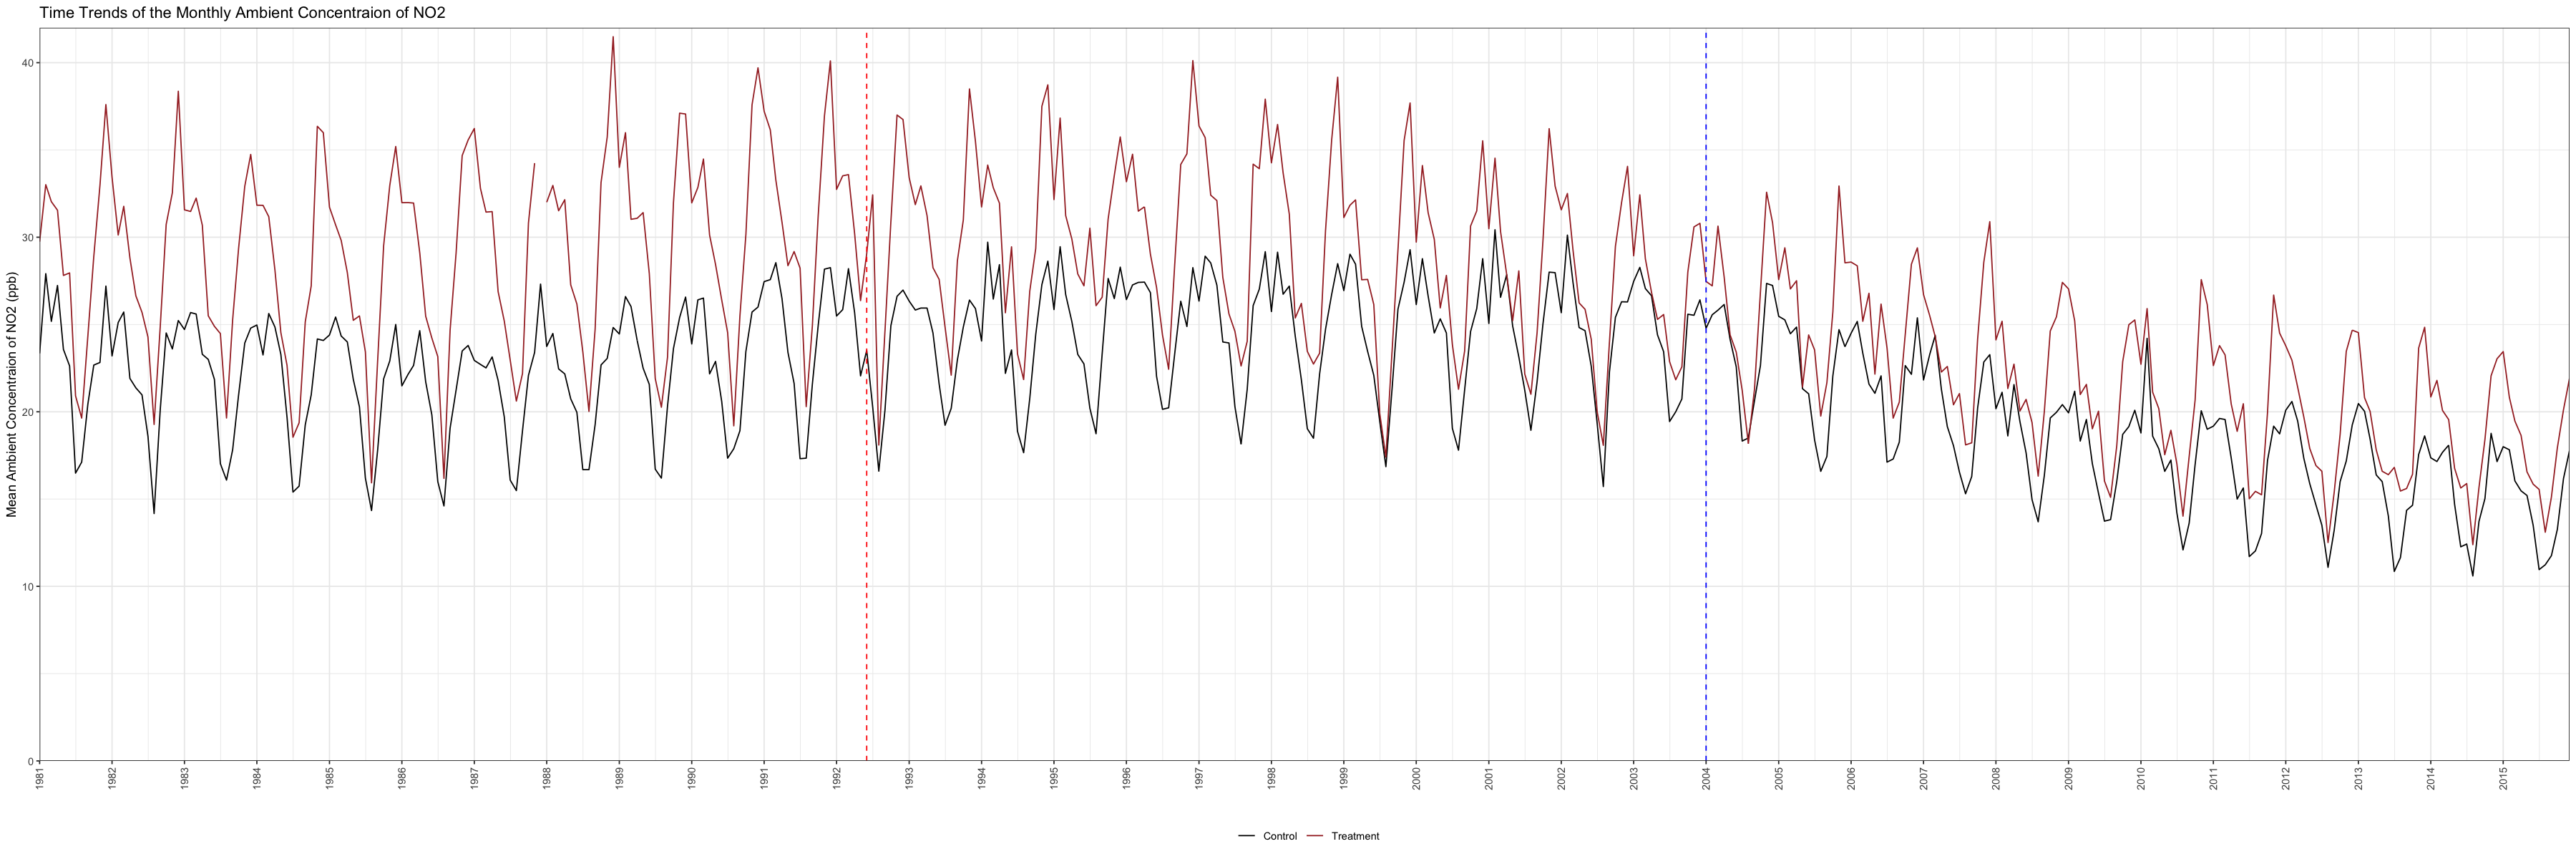

In [445]:
nnd_graph <- df %>% 
    group_by(y_date, treatment1992) %>%
    summarize(average_ndd_mean = mean(average_ndd))

# plot the mean of average_ndd
ggplot(data = nnd_graph, 
       mapping = aes(y=average_ndd_mean,
                    x=y_date,
                    color=factor(treatment1992))) +
  geom_line(size = 0.5) +
  guides(color = guide_legend(title = element_blank())) +
  scale_color_manual(labels = c("Control", "Treatment"), 
                     values = c("black", "brown")) +
  labs(x="", 
       y = "Mean Ambient Concentration of NO2 (ppb)",
       title = "Time Trends of the Monthly Ambient Concentraion of NO2") +
  scale_x_date(date_breaks = "1 year", date_labels = "%Y", expand = c(0, 0)) +
  scale_y_continuous(limits = c(0, 42), expand = c(0,0)) +
  # Intervention is June 1992
  geom_vline(xintercept = as.Date("1992-06-01"), linetype = "dashed", color = "red") +
  # government support in 2004
  geom_vline(xintercept = as.Date("2004-01-01"), linetype = "dashed", color = "blue") +
  theme_bw() + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), 
        legend.position = "bottom")

In [519]:
head(df)

,y_month,y_date,lnaverage_ndd,lnhmax_ndd,treatment_effects,temp,precip,wind,daylight,snow,cloud,treatment1992,m_code,dabove_nd,average_ndd,month,year,max_ndd
,<dbl>,<date>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,252,1981-01-01,3.044523,4.094345,0,-4.9,162.0,1.5,134.3,273,7.3,0,1101080,0,21,1,1981,60
2,252,1981-01-01,3.465736,4.605170,0,3.9,6.0,2.4,222.4,0,3.0,1,12204520,0,32,1,1981,100
3,252,1981-01-01,3.610918,4.382027,0,4.4,3.5,3.5,233.4,0,2.9,1,13112510,0,37,1,1981,80
4,252,1981-01-01,3.091043,4.700480,0,4.4,3.5,3.5,233.4,0,2.9,1,11214030,0,22,1,1981,110
5,252,1981-01-01,3.784190,4.700480,0,4.4,4.0,2.2,218.0,0,2.9,1,14101520,2,44,1,1981,110
6,252,1981-01-01,3.610918,4.605170,0,4.4,3.5,3.5,233.4,0,2.9,1,13108520,0,37,1,1981,100


In [589]:
df$hmax_ndd <- exp(df$lnhmax_ndd) %>% round(2)
head(df)

,y_month,y_date,lnaverage_ndd,lnhmax_ndd,treatment_effects,temp,precip,wind,daylight,snow,cloud,treatment1992,m_code,dabove_nd,average_ndd,month,year,max_ndd,hmax_ndd
,<dbl>,<date>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,252,1981-01-01,3.044523,4.094345,0,-4.9,162.0,1.5,134.3,273,7.3,0,1101080,0,21,1,1981,60,60
2,252,1981-01-01,3.465736,4.605170,0,3.9,6.0,2.4,222.4,0,3.0,1,12204520,0,32,1,1981,100,100
3,252,1981-01-01,3.610918,4.382027,0,4.4,3.5,3.5,233.4,0,2.9,1,13112510,0,37,1,1981,80,80
4,252,1981-01-01,3.091043,4.700480,0,4.4,3.5,3.5,233.4,0,2.9,1,11214030,0,22,1,1981,110,110
5,252,1981-01-01,3.784190,4.700480,0,4.4,4.0,2.2,218.0,0,2.9,1,14101520,2,44,1,1981,110,110
6,252,1981-01-01,3.610918,4.605170,0,4.4,3.5,3.5,233.4,0,2.9,1,13108520,0,37,1,1981,100,100


In [630]:
df %>%
    # mean hourly max ndd of all monitors by month & year
    group_by(year, month, treatment1992) %>%
    summarize(hmax_max_yearly = mean(hmax_ndd)) %>%
    # of the previous mean by month take the max per year
    group_by(year, treatment1992) %>%
    summarize(hmax_max_yearly_test = max(hmax_max_yearly))

`summarise()` has grouped output by 'year', 'month'. You can override using the
`.groups` argument.


year,month,treatment1992,hmax_max_yearly
<dbl>,<dbl>,<int>,<dbl>
1981,1,0,64.28571
1981,1,1,91.73913
1981,2,0,71.76471
1981,2,1,95.00000
1981,3,0,70.90909
1981,3,1,101.03261
1981,4,0,80.88235
1981,4,1,93.82857
1981,5,0,73.71429


`summarise()` has grouped output by 'year', 'month'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


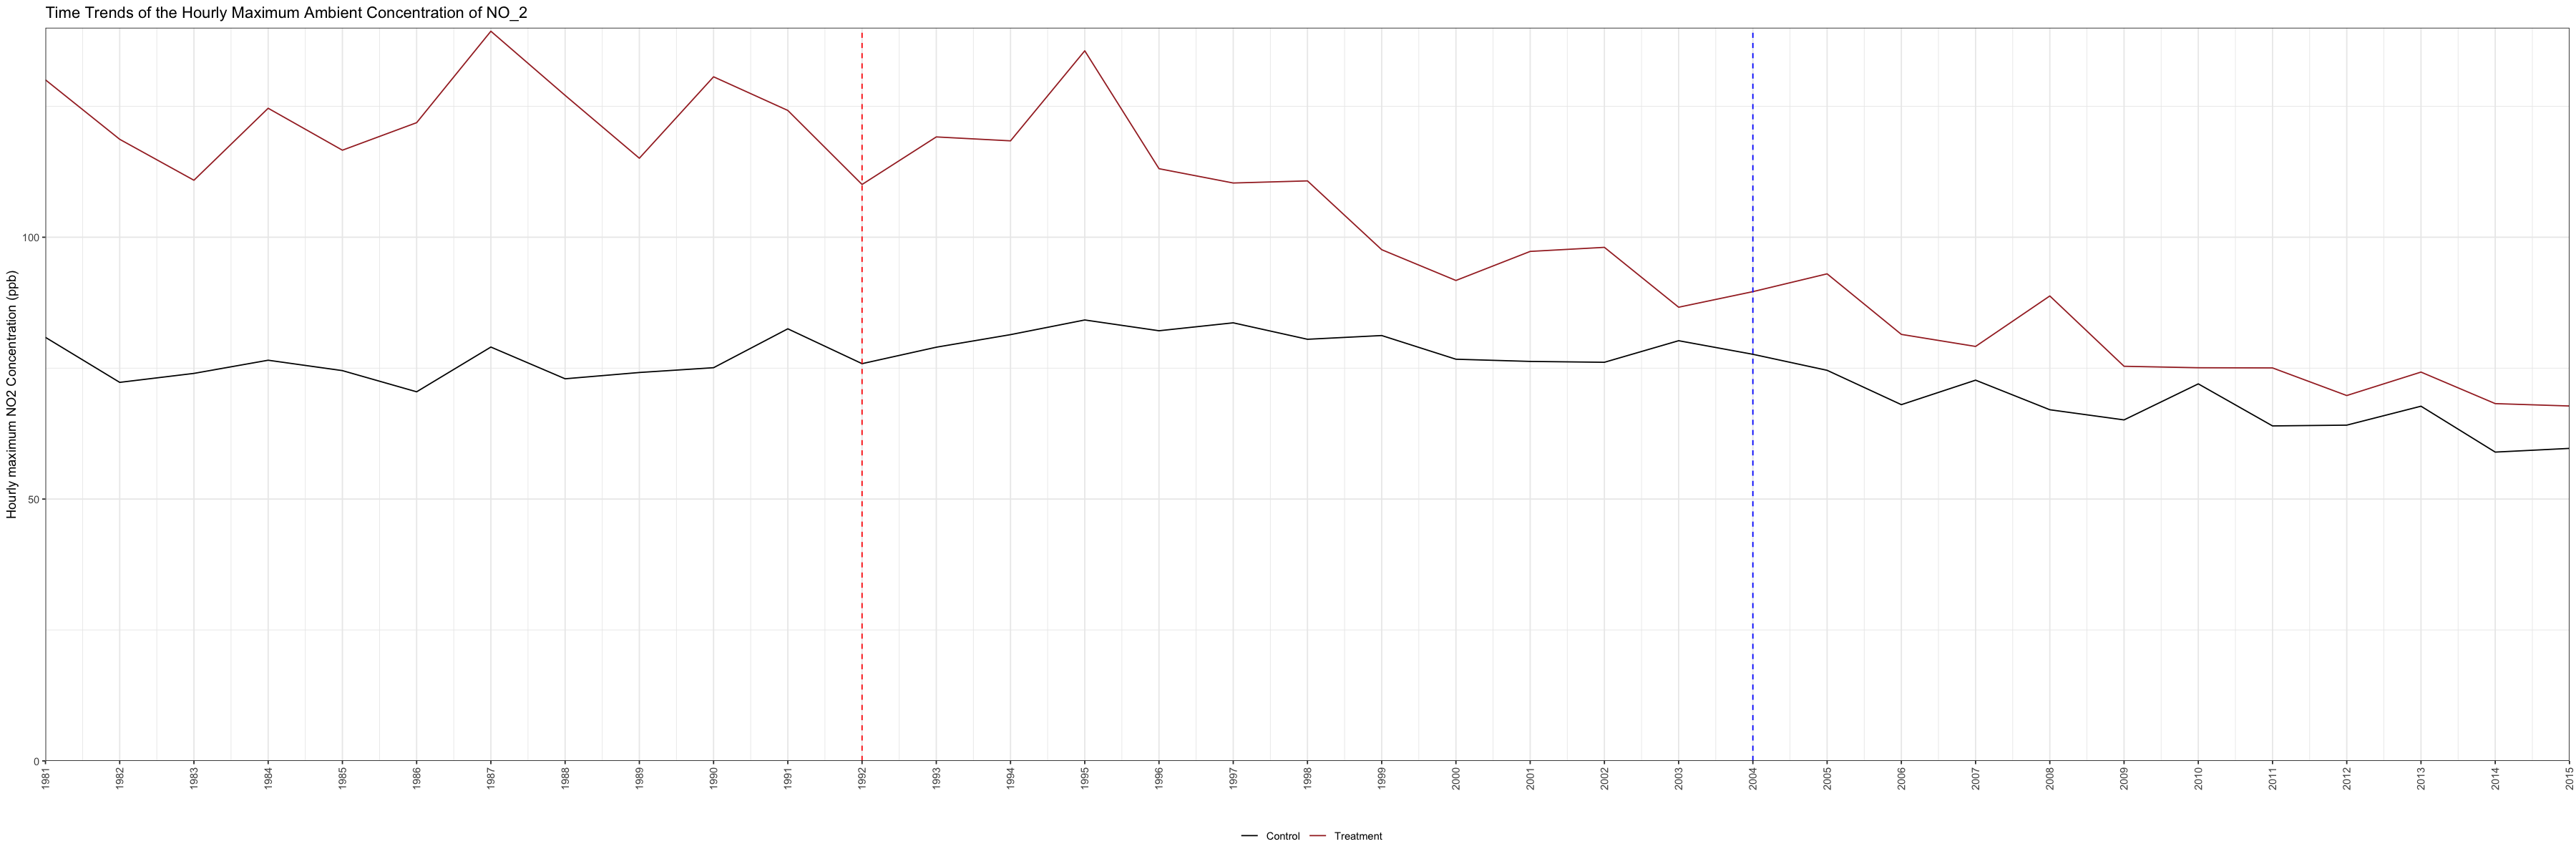

In [629]:
# nnd_graph <- df %>%
#     group_by(year, treatment1992) %>%
#     summarize(mean_max_ndd = mean(max_ndd))

nnd_graph <- df %>%
    # mean hourly ndd per monitor (year / month)
    group_by(year, month, treatment1992) %>%
    summarize(hmax_max_yearly = mean(hmax_ndd)) %>%
    group_by(year, treatment1992) %>%
    summarize(hmax_max_yearly_test = max(hmax_max_yearly))

# plot the mean of max_ndd
ggplot(data = nnd_graph, 
       mapping = aes(y=hmax_max_yearly_test,
                    x=year,
                    color=factor(treatment1992))) +
  geom_line(size = 0.5) +
  guides(color = guide_legend(title = element_blank())) +
  scale_color_manual(labels = c("Control", "Treatment"), 
                     values = c("black", "brown")) +
  labs(x="", 
       y = "Hourly maximum NO2 Concentration (ppb)",
       title = "Time Trends of the Hourly Maximum Ambient Concentration of NO_2") +  
  scale_x_continuous(breaks = seq(1981, 2015, 1), limits = c(1981, 2015), expand = c(0, 0)) +
  scale_y_continuous(limits = c(0, 140), expand = c(0,0)) +
  # Intervention is June 1992
  geom_vline(xintercept = 1992, linetype = "dashed", color = "red") +
  # government support in 2004
  geom_vline(xintercept = 2004, linetype = "dashed", color = "blue") +
  theme_bw() + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), 
        legend.position = "bottom")

In [693]:
etable(model1, model2, model3, vcov = "twoway", title = "Estimated Effects of Designation under the ANCL on Air Pollution")

,,model1,model2,model3
,<chr>,<chr>,<chr>,<chr>
1,Dependent Var.:,lnaverage_ndd,lnaverage_ndd,lnaverage_ndd
2,,,,
3,treatment_effects,-0.1288*** (0.0160),-0.1144*** (0.0168),-0.1280*** (0.0155)
4,temp,,0.0065 (0.0074),0.0168. (0.0081)
5,precip,,-0.0001 (7.48e-5),0.0002. (9.92e-5)
6,daylight,,-0.0038*** (0.0004),-0.0005* (0.0002)
7,snow,,0.0029*** (0.0004),0.0025*** (0.0003)
8,wind,,-0.0068 (0.0180),-0.0702*** (0.0115)
9,cloud,,-0.1506*** (0.0157),-0.0452*** (0.0092)


In [697]:
summary(model2, vcov = "twoway")

OLS estimation, Dep. Var.: lnaverage_ndd
Observations: 90,425 
Fixed-effects: month: 12,  m_code: 225
Standard-errors: Clustered (month & m_code) 
                   Estimate Std. Error   t value   Pr(>|t|)    
treatment_effects -0.114375   0.016821 -6.799540 2.9556e-05 ***
temp               0.006458   0.007423  0.869883 4.0295e-01    
precip            -0.000111   0.000075 -1.479227 1.6714e-01    
daylight          -0.003841   0.000388 -9.895902 8.2071e-07 ***
snow               0.002923   0.000429  6.807207 2.9256e-05 ***
wind              -0.006828   0.018042 -0.378450 7.1230e-01    
cloud             -0.150589   0.015698 -9.593185 1.1178e-06 ***
... 2 variables were removed because of collinearity (treatment1992 and treatment_effects:treatment1992)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.226214     Adj. R2: 0.72764 
                 Within R2: 0.138959

In [638]:
# model1 <- feols(fml = lnaverage_ndd ~ treatment_effects * treatment1992 | month + m_code, data = df)
# etable(model1, model2, model3, title = "Estimated Effects of Designation under the ANCL on Air Pollution")
predictions <- data.frame(lnaverage_ndd_pred = predict(model1, df))

In [698]:
head(df)

,y_month,y_date,lnaverage_ndd,lnhmax_ndd,treatment_effects,temp,precip,wind,daylight,snow,cloud,treatment1992,m_code,dabove_nd,average_ndd,month,year,max_ndd,hmax_ndd
,<dbl>,<date>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,252,1981-01-01,3.044523,4.094345,0,-4.9,162.0,1.5,134.3,273,7.3,0,1101080,0,21,1,1981,60,60
2,252,1981-01-01,3.465736,4.605170,0,3.9,6.0,2.4,222.4,0,3.0,1,12204520,0,32,1,1981,100,100
3,252,1981-01-01,3.610918,4.382027,0,4.4,3.5,3.5,233.4,0,2.9,1,13112510,0,37,1,1981,80,80
4,252,1981-01-01,3.091043,4.700480,0,4.4,3.5,3.5,233.4,0,2.9,1,11214030,0,22,1,1981,110,110
5,252,1981-01-01,3.784190,4.700480,0,4.4,4.0,2.2,218.0,0,2.9,1,14101520,2,44,1,1981,110,110
6,252,1981-01-01,3.610918,4.605170,0,4.4,3.5,3.5,233.4,0,2.9,1,13108520,0,37,1,1981,100,100


In [739]:
# treatment_effects * treatment1992
model1_v2 <- feols(fml = lnaverage_ndd ~ treatment_effects + temp + precip + daylight + snow + wind + cloud | month + m_code, vcov = "iid", data = df)

In [761]:
treatment_date <- ymd("1992-06-01")

model_with_fe_month_coefs <- tidy(model1_v2) |>
  mutate(
    term = str_remove(term, "TRUE"),
    ci_up = estimate + qnorm(0.975) * std.error,
    ci_low = estimate + qnorm(0.025) * std.error
  ) |>
  left_join(
    variables,
    by = c("term" = "variable_name")
  )

ERROR: Error in is.data.frame(y): object 'variables' not found
